# Route Vizualization
### Huanlin Dai

Proof of concept: graphing routes

In [1]:
import folium
import networkx as nx
import osmnx as ox
import pandas as pd
import configparser

In [2]:
def find_bbox(coords):
    """
    Given a list of coordinates (longitude and latitude),
    find a bounding box that contains all the points of interest.
    This function helps reduce the number of nodes and edges in a
    osmnx graph to reduce computational complexity/time.
    Parameters:
        coords : pd.DataFrame
    Returns:
        n, s, e, w : float
    """
    if len(coords) == 0:
        raise ValueError("find_bbox :: no coords inputted")
    n, s, e, w = [
        coords["Latitude"].iloc[0],
        coords["Latitude"].iloc[0],
        coords["Longitude"].iloc[0],
        coords["Longitude"].iloc[0],
    ]
    for i in range(len(coords)):
        longitude = coords["Longitude"].iloc[i]
        latitude = coords["Latitude"].iloc[i]
        n, s, e, w = [
            max(latitude, n),
            min(latitude, s),
            max(longitude, e),
            min(longitude, w),
        ]
    nspad = 1.5 * (n-s)
    ewpad = 1.5 * (e-w)
    return n + nspad, s - nspad, e + ewpad, w - ewpad

In [3]:
def osmnx_to_latlon(graph, routes):
    """
    given a route created by osmnx (node numbers), create a list of x, y
    coordinates to draw on folium

    Parameters:
        graph : osmnx graph
        routes : list of osmnx routes (routes are usually lists of nodes)
    Returns:
        list of (lat, lon) coordinates
    """
    final_route = []
    for route in routes:
        for point in route:
            final_route.append(
                (graph.nodes[point]["y"], graph.nodes[point]["x"])
            )
    return final_route

In [4]:
def calc_routes(graph, coords):
    """
    Takes in a graph and a set of coordinates (w/ columns "Longitude" and
    "Latitude") and returns the set of shortest routes between each coordinate

    Parameters:
        graph : osmnx graph
        coords : dataframe
    Returns:
        routes: list of routes

    """
    routes = []

    for i in range(len(coords) - 1):
        start_node = ox.nearest_nodes(
            graph, coords.iloc[i]["Longitude"], coords.iloc[i]["Latitude"]
        )
        end_node = ox.nearest_nodes(
            graph,
            coords.iloc[i + 1]["Longitude"],
            coords.iloc[i + 1]["Latitude"],
        )
        routes.append(
            nx.shortest_path(graph, start_node, end_node, weight="length")
        )

    return osmnx_to_latlon(graph, routes)

In [5]:
def add_markers(f_map, route_df, color):
    """
    given a folium map, route data (includes location names), and a color (str),
    draw markers on the given map

    Parameters:
        f_map : folium map
        route_data : pd.DataFrame
        color : str (e.g., "red", "blue")
    """

    # icon_size = 100
    for i in range(len(route_df)):
        row = route_df.iloc[i]
        loc_name = row["Name"]
        y, x = row[["Latitude", "Longitude"]]
        address = row["Address"]
        dropoff, pickup = row[["Weekly_Dropoff_Totes", "Daily_Pickup_Totes"]]
        popup_html = f"""
                Name: {loc_name}
                <br>
                Address: {address}
                <br>
                Dropoff (weekly): {dropoff}
                <br>
                Pickup (daily): {pickup}
                """
        popup = folium.Popup(popup_html, max_width=700)

        folium.Marker(
            (y, x), popup=popup, parse_html=True, icon=folium.Icon(color=color)
        ).add_to(f_map)
        
    return None


In [12]:
config = configparser.ConfigParser()
config.read('../utils/config.ini')
cfg = config['route.viz']

In [13]:
place = cfg['place']
FUE_path = cfg['FUE_path']
route_path = cfg['route_path']
latitude = float(cfg['latitude'])
longitude = float(cfg['longitude'])
save_path = cfg['save_path']

feu_galveston = pd.read_csv(FUE_path)
route_data = pd.read_csv(route_path)
location = [latitude, longitude]
coords = route_data[["Longitude", "Latitude"]]

In [14]:
n, s, e, w = find_bbox(coords)
graph = ox.graph_from_place(place, network_type="drive")
galv_graph = ox.truncate.truncate_graph_bbox(
    graph,
    n, s, e, w,
    truncate_by_edge=False,
    retain_all=False,
    quadrat_width=0.05,
    min_num=3,
)

In [15]:
route = calc_routes(galv_graph, coords)

In [16]:
map = folium.Map(
    location=location, tiles="OpenStreetMap", zoom_start=11
)
add_markers(map, route_data, "blue")
# add_markers(map, route_2_data, "red")
folium.PolyLine(locations=route, color="blue").add_to(map)
# folium.PolyLine(locations=route_2, color="red").add_to(map)

for y, x in route:
    folium.CircleMarker(
        location=[y, x], radius=2, weight=5, color="yellow"
    ).add_to(map)

map.save(save_path)

In [17]:
map

In [17]:
# start_node = ox.nearest_nodes(
#     graph, coords.iloc[i]["Longitude"], coords.iloc[i]["Latitude"]
# )
# end_node = ox.nearest_nodes(
#     graph,
#     coords.iloc[i + 1]["Longitude"],
#     coords.iloc[i + 1]["Latitude"],
# )

# print(f"start node: {start_node}")
# print(f"end node: {end_node}")

X, Y = coords[['Longitude', 'Latitude']].iloc[0]
chkn = ox.distance.nearest_edges(graph, X, Y, interpolate=None, return_dist=False)
chkn

(387828564, 224420054, 0)

In [18]:
graph[387828564]

AdjacencyView({224420054: {0: {'osmid': 20891463, 'oneway': True, 'highway': 'unclassified', 'reversed': False, 'length': 15.879}}, 387828679: {0: {'osmid': 561130178, 'oneway': True, 'name': 'Hope Boulevard', 'highway': 'tertiary', 'reversed': False, 'length': 53.318}}})

(224473994, 224469307, 0)


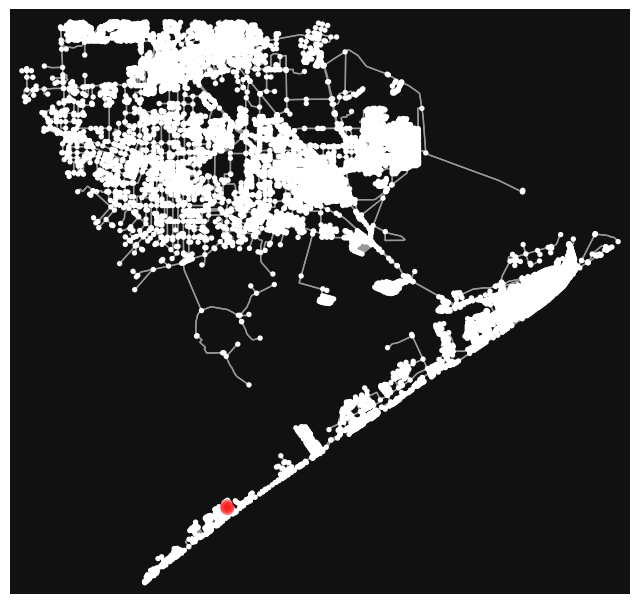

In [43]:
X, Y = coords[['Longitude', 'Latitude']].iloc[13]
n = max(X
galv_graph = ox.truncate.truncate_graph_bbox(
    graph,
    n, s, e, w,
    truncate_by_edge=False,
    retain_all=False,
    quadrat_width=0.05,
    min_num=3,
)
chkn = ox.distance.nearest_edges(galv_graph, X, Y, interpolate=None, return_dist=False)
print(chkn)
fig, ax = ox.plot.plot_graph_route(galv_graph, (chkn[0], chkn[1]), route_color='r', )